# 循环神经网络的从零开始实现



In [1]:
import sys
sys.path.append('..')

In [ ]:
%matplotlib inline
import math
import mindspore as ms
import numpy as np
import mindspore.nn as nn
from mindspore import Tensor, Parameter, ParameterTuple, mint
import mindspore.ops as ops
from d2l import mindspore as d2l

batch_size, num_steps = 32, 35
# 加载数据 (Time Machine)
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [3]:
ops.one_hot(Tensor([0, 2], ms.int32), len(vocab), Tensor(1.0, ms.float32), Tensor(0.0, ms.float32))

Tensor(shape=[2, 28], dtype=Float32, value=
[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

小批量数据形状是（批量大小,时间步数）

In [4]:
X = d2l.reshape(d2l.arange(10), (2, 5))
ops.one_hot(Tensor(X.T, ms.int32), 28, Tensor(1.0, ms.float32), Tensor(0.0, ms.float32)).shape

(5, 2, 28)

初始化循环神经网络模型的模型参数

In [5]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return np.random.normal(scale=0.01, size=shape).astype(np.float32)
    
    # 隐藏层参数
    W_xh = Parameter(normal((num_inputs, num_hiddens)), name="W_xh")
    W_hh = Parameter(normal((num_hiddens, num_hiddens)), name="W_hh")
    b_h = Parameter(d2l.zeros(num_hiddens), name="b_h")
    # 输出层参数
    W_hq = Parameter(normal((num_hiddens, num_outputs)), name="W_hq")
    b_q = Parameter(d2l.zeros(num_outputs), name="b_q")
    
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return ParameterTuple(params)

一个`init_rnn_state`函数在初始化时返回隐状态

In [6]:
def init_rnn_state(batch_size, num_hiddens):
    return (d2l.zeros((batch_size, num_hiddens)), )

下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出

In [ ]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    for X in inputs:
        H = mint.tanh(mint.matmul(X, W_xh) + mint.matmul(H, W_hh) + b_h)
        Y = mint.matmul(H, W_hq) + b_q
        outputs.append(Y)
    # d2l.concat -> mint.cat
    return mint.cat(outputs, dim=0), (H, )

创建一个类来包装这些函数

In [8]:
class RNNModelScratch(nn.Cell): 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens,
                 get_params, init_state, forward_fn):
        super().__init__()
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def construct(self, X, state):
        X = ops.one_hot(X.T, self.vocab_size, Tensor(1.0, ms.float32), Tensor(0.0, ms.float32))
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

检查输出是否具有正确的形状

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

.

((10, 28), 1, (2, 512))

首先定义预测函数来生成`prefix`之后的新字符

In [10]:
def predict_ch8(prefix, num_preds, net, vocab):  #@save
    """在`prefix`后面生成新字符"""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(Tensor([outputs[-1]], ms.int32), (1,1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1).asnumpy()))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab)

'time traveller rrrrrrrrrr'

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [11]:
def grad_clipping(grads, theta):  #@save
    """裁剪梯度。"""
    norm = mint.sqrt(sum(mint.sum(g ** 2) for g in grads))
    
    if norm > theta:
        for g in grads:
            g[:] *= theta / norm

定义一个函数在一个迭代周期内训练模型

In [12]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和，词元数量
    
    def forward_fn(x, state, y):
        y_hat, state = net(x, state)
        l = loss(y_hat, y).mean()
        return l
    
    grad_fn = ms.value_and_grad(forward_fn, None, weights=net.trainable_params())
    net.set_train()
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0])
        y = Y.T.reshape(-1)
        (l), grads = grad_fn(X, state, y)
        grad_clipping(grads, 1)
        if isinstance(updater, nn.Optimizer):
            updater(grads)
        else:
            updater(batch_size=1)
        metric.add(l.asnumpy() * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现

In [13]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    if isinstance(net, nn.Cell):
        updater = nn.SGD(net.trainable_params(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.5, 24256.8 词元/秒
time traveller held in his hand was a glitteringmetallic framewo
travelleryou can show black is white by argument said filby


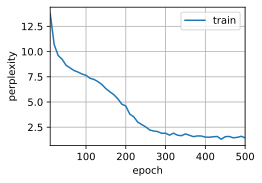

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs)

现在，我们训练循环神经网络模型

困惑度 1.5, 34042.7 词元/秒
time traveller smiled round at us then still smiling faintlyand 
traveller smiled round at us then still smiling faintlyand 


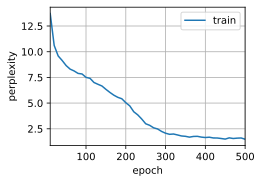

In [15]:
_train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)
_net = RNNModelScratch(len(vocab), num_hiddens, get_params, init_rnn_state, rnn)
train_ch8(_net, _train_iter, vocab, lr, num_epochs, use_random_iter=True)